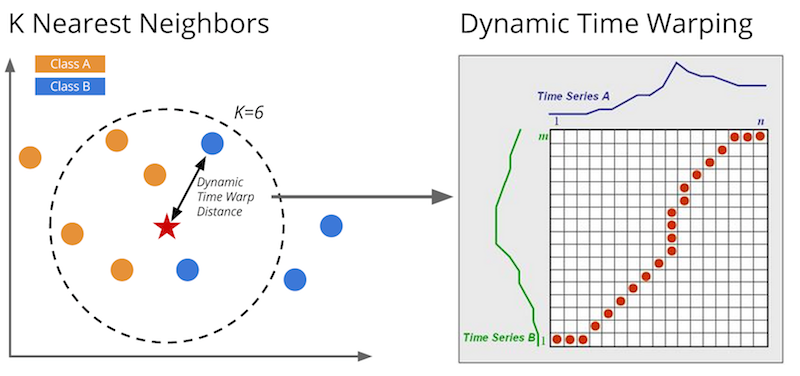

In [2]:
from IPython.display import Image
Image('dtw_knn_schematic.png', width=780)

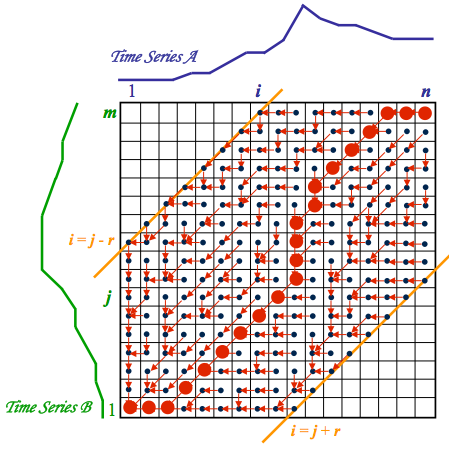

In [3]:
Image('max_window_warping.png')

In [14]:
import sys
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform

plt.style.use('bmh')
%matplotlib inline

try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN
        
    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function
            
    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """
    
    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer
            
        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """
        
        self.x = x
        self.l = l
        
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared
        
        d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function
        
        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxsize * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window 
        return cost[-1, -1]
    
    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        
        y : array of shape [n_samples, n_timepoints]
        
        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """
        
        # Compute the distance matrix        
        dm_count = 0
        
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            
            p = ProgressBar(shape(dm)[0])
            
            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                      y[j, ::self.subsample_step])
                    
                    dm_count += 1
                    p.animate(dm_count)
            
            # Convert to squareform
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0])) 
            dm_size = x_s[0]*y_s[0]
            
            p = ProgressBar(dm_size)
        
            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
                    p.animate(dm_count)
        
            return dm
        
    def predict(self, x):
        """Predict the class labels or probability estimates for 
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified
          
        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels 
              (2) the knn label count probability
        """
        
        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()

class ProgressBar:
    """This progress bar was taken from PYMC
    """
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        print('\r', self,
        sys.stdout.flush())
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

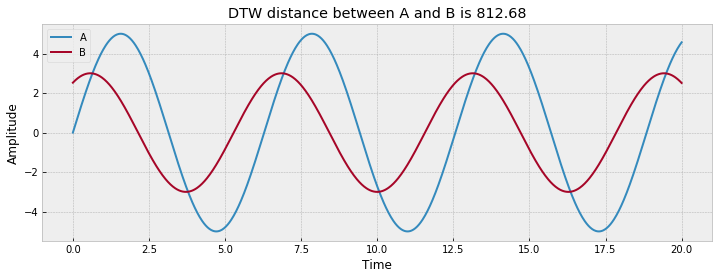

In [15]:
time = np.linspace(0,20,1000)
amplitude_a = 5*np.sin(time)
amplitude_b = 3*np.sin(time + 1)

m = KnnDtw()
distance = m._dtw_distance(amplitude_a, amplitude_b)

fig = plt.figure(figsize=(12,4))
_ = plt.plot(time, amplitude_a, label='A')
_ = plt.plot(time, amplitude_b, label='B')
_ = plt.title('DTW distance between A and B is %.2f' % distance)
_ = plt.ylabel('Amplitude')
_ = plt.xlabel('Time')
_ = plt.legend()

In [16]:
m._dist_matrix(np.random.random((4,50)), np.random.random((4,50)))

 [                  0%                  ] None
 [*****            12%                  ]  2 of 16 complete None
 [*******          19%                  ]  3 of 16 complete None
 [**********       25%                  ]  4 of 16 complete None
 [************     31%                  ]  5 of 16 complete None
 [**************   38%                  ]  6 of 16 complete None
 [*****************44%                  ]  7 of 16 complete None
 [*****************50%                  ]  8 of 16 complete None
 [*****************56%*                 ]  9 of 16 complete None
 [*****************62%****              ]  10 of 16 complete None
 [*****************69%******            ]  11 of 16 complete None
 [*****************75%********          ]  12 of 16 complete None
 [*****************81%***********       ]  13 of 16 complete None
 [*****************88%*************     ]  14 of 16 complete None
 [*****************94%****************  ]  15 of 16 complete None
 [****************100%***************

array([[9.19900981, 9.26573535, 9.25476499, 9.16457024],
       [9.13268058, 8.36573525, 9.3979415 , 9.96530014],
       [9.87805453, 8.46787251, 8.14805439, 8.74316262],
       [7.89254166, 8.84807012, 8.71208541, 7.6246552 ]])

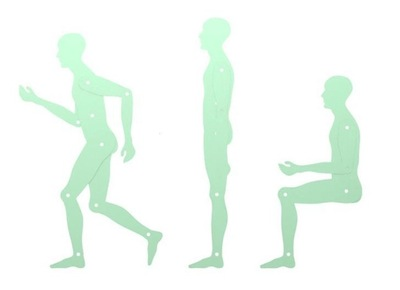

In [18]:
Image('stand-sit-run.jpg')

In [20]:
# Import the HAR dataset
x_train_file = open('data/UCI-HAR-Dataset/train/X_train.txt', 'r')
y_train_file = open('data/UCI-HAR-Dataset/train/y_train.txt', 'r')

x_test_file = open('data/UCI-HAR-Dataset/test/X_test.txt', 'r')
y_test_file = open('data/UCI-HAR-Dataset/test/y_test.txt', 'r')

# Create empty lists
x_train = []
y_train = []
x_test = []
y_test = []

# Mapping table for classes
labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}

# Loop through datasets
for x in x_train_file:
    x_train.append([float(ts) for ts in x.split()])
    
for y in y_train_file:
    y_train.append(int(y.rstrip('\n')))
    
for x in x_test_file:
    x_test.append([float(ts) for ts in x.split()])
    
for y in y_test_file:
    y_test.append(int(y.rstrip('\n')))
    
# Convert to numpy for efficiency
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

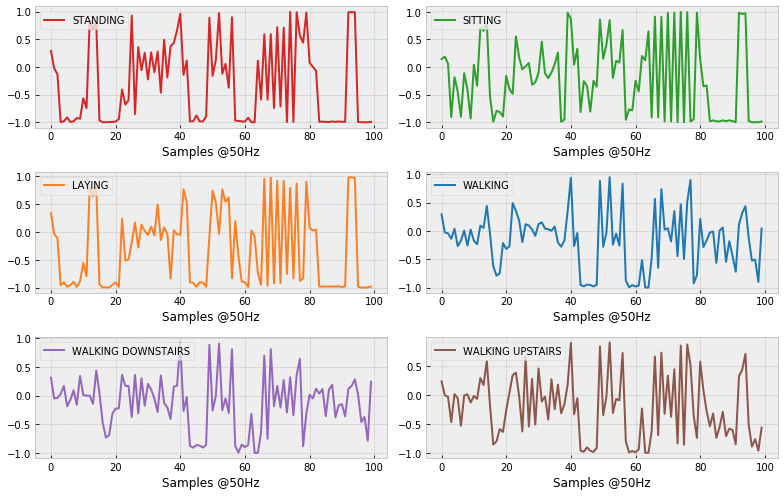

In [21]:
plt.figure(figsize=(11,7))
colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD',
          '#8C564A','#7F7F7F','#1FBECF','#E377C2','#BCBD27']

for i, r in enumerate([0,27,65,100,145,172]):
    plt.subplot(3,2,i+1)
    plt.plot(x_train[r][:100], label=labels[y_train[r]], color=colors[i], linewidth=2)
    plt.xlabel('Samples @50Hz')
    plt.legend(loc='upper left')
    plt.tight_layout()

In [44]:
m = KnnDtw(n_neighbors=1, max_warping_window=10)
m.fit(x_train[::1000], y_train[::100])
label, proba = m.predict(x_test[::100])

 [                  0%                  ] None
 [                  1%                  ]  2 of 240 complete None
 [                  1%                  ]  3 of 240 complete None
 [*                 2%                  ]  4 of 240 complete None
 [*                 2%                  ]  5 of 240 complete None
 [*                 2%                  ]  6 of 240 complete None
 [*                 3%                  ]  7 of 240 complete None
 [*                 3%                  ]  8 of 240 complete None
 [**                4%                  ]  9 of 240 complete None
 [**                4%                  ]  10 of 240 complete None
 [**                5%                  ]  11 of 240 complete None
 [**                5%                  ]  12 of 240 complete None
 [**                5%                  ]  13 of 240 complete None
 [**                6%                  ]  14 of 240 complete None
 [**                6%                  ]  15 of 240 complete None
 [***               7% 

 [*****************52%                  ]  124 of 240 complete None
 [*****************52%                  ]  125 of 240 complete None
 [*****************52%                  ]  126 of 240 complete None
 [*****************53%                  ]  127 of 240 complete None
 [*****************53%                  ]  128 of 240 complete None
 [*****************54%*                 ]  129 of 240 complete None
 [*****************54%*                 ]  130 of 240 complete None
 [*****************55%*                 ]  131 of 240 complete None
 [*****************55%*                 ]  132 of 240 complete None
 [*****************55%*                 ]  133 of 240 complete None
 [*****************56%*                 ]  134 of 240 complete None
 [*****************56%*                 ]  135 of 240 complete None
 [*****************57%**                ]  136 of 240 complete None
 [*****************57%**                ]  137 of 240 complete None
 [*****************57%**                ]  138 o

C:\Users\kwakms123\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                    precision    recall  f1-score   support

           WALKING       0.00      0.00      0.00         5
  WALKING UPSTAIRS       0.00      0.00      0.00         0
WALKING DOWNSTAIRS       0.75      0.75      0.75         4
           SITTING       0.62      0.56      0.59         9
          STANDING       0.00      0.00      0.00         8
            LAYING       0.00      0.00      0.00         4

          accuracy                           0.27        30
         macro avg       0.23      0.22      0.22        30
      weighted avg       0.29      0.27      0.28        30



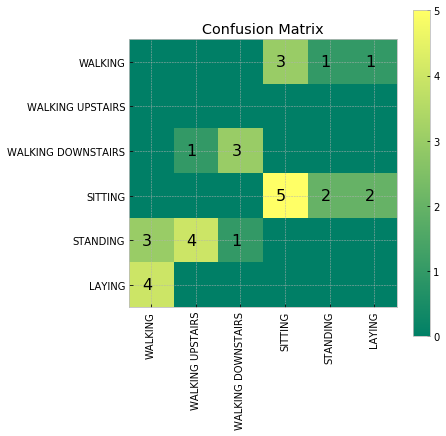

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(label, y_test[::100],target_names=[l for l in labels.values()]))

conf_mat = confusion_matrix(label, y_test[::100])

fig = plt.figure(figsize=(6,6))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(6), [l for l in labels.values()], rotation=90)
_ = plt.yticks(range(6), [l for l in labels.values()])

 [                  0%                  ] None
 [*****************50%                  ]  2 of 4 complete None
 [*****************75%********          ]  3 of 4 complete None
 [****************100%******************]  4 of 4 complete None
 [                  0%                  ] None
 [*****************50%                  ]  2 of 4 complete None
 [*****************75%********          ]  3 of 4 complete None
 [****************100%******************]  4 of 4 complete None
 [                  0%                  ] None
 [*****************50%                  ]  2 of 4 complete None
 [*****************75%********          ]  3 of 4 complete None
 [****************100%******************]  4 of 4 complete None
 [                  0%                  ] None
 [*****************50%                  ]  2 of 4 complete None
 [*****************75%********          ]  3 of 4 complete None
 [****************100%******************]  4 of 4 complete None
 [                  0%                  ] No

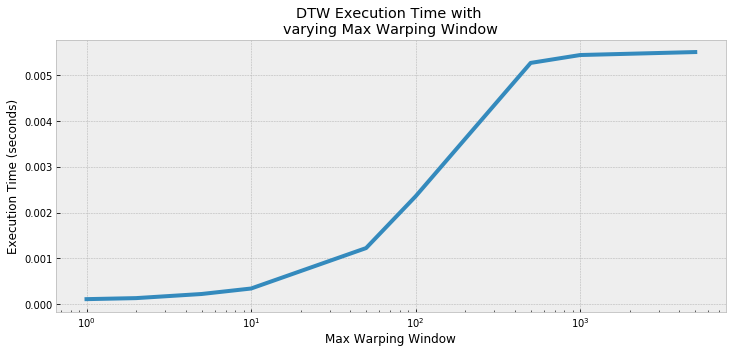

In [41]:
import time

time_taken = []
windows = [1,2,5,10,50,100,500,1000,5000]

for w in windows:
    begin = time.time()
    
    t = KnnDtw(n_neighbors=1, max_warping_window=w)
    t.fit(x_train[:2], y_train[:2])
    label, proba = t.predict(x_test[:2])
    
    end = time.time()
    time_taken.append(end - begin)

fig = plt.figure(figsize=(12,5))
_ = plt.plot(windows, [t/400. for t in time_taken], lw=4)
plt.title('DTW Execution Time with \nvarying Max Warping Window')
plt.ylabel('Execution Time (seconds)')
plt.xlabel('Max Warping Window')
plt.xscale('log')

In [47]:
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()